In [1]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

import matplotlib.pyplot as plt
import scipy.io
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

from sklearn.manifold import TSNE
import seaborn as sns

import pandas as pd
import xlsxwriter
import numpy as np

tf.get_logger().setLevel('ERROR')

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
loaded_model = tf.keras.models.load_model('models/96/96_1Dense_0.3Val_1Drop0.3_model-improvement-35-0.97')

intermediate_layer_model = tf.keras.Model(inputs=loaded_model.get_layer("text").input,
                                       outputs=loaded_model.get_layer("dense2").output)


intermediate_layer_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [3]:
data = pd.read_csv(r'C:\Users\MOHSEN-ASUS\JupyterProjects\bert classification\final_dataset_for_bert.csv')

In [4]:
embbeding_size = 96

In [5]:
def get_BERTembbedings(text, model):
    
    text = [text]
    text_tensor = tf.convert_to_tensor(text, dtype=tf.string)
    model_output = model(text_tensor)
    
    return model_output

In [6]:
def embbedings_labels_generator(dataset, selected_classes, BERT, embbeding_size=embbeding_size):
    
    # an array for labels
    labels = np.array([])
    
    # in the line below i am creating a zero array to append my embbedings to it (i dont know how to do it without creating a zero)
    class_texts_embbedings = np.zeros([1, embbeding_size])
    
    for i in selected_classes:
        
        # getting all of the texts belong to class i
        class_texts = dataset[dataset["class"] == i]
        class_texts = class_texts["text"]
        
        for j in class_texts:
            
            # obtaining embbedings of class i texts using "get_BERTembbedings" and appending them to an array
            class_texts_embbedings = np.append(class_texts_embbedings, get_BERTembbedings(j, BERT), axis=0)
            
            # putting labels in labels array
            labels = np.append(labels, i)  
            
        
    # deleting the zero array from the first row
    class_texts_embbedings = np.delete(class_texts_embbedings, 0, 0)
    
    return class_texts_embbedings, labels

In [7]:
class_name = ["Antelope"]

my_embbedings, my_labels = embbedings_labels_generator(data, class_name, intermediate_layer_model)

In [8]:
def att_generator(embbedings):
    
    the_attribute = np.sum(my_embbedings, axis=0)
    
    return the_attribute

In [9]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [10]:
myatt= att_generator(my_embbedings)
myatt.shape

(96,)

In [11]:
all_classes = data["class"].unique()
attribute_array = np.zeros([1, embbeding_size])

for i in all_classes:
    
    my_embbedings, my_labels = embbedings_labels_generator(data, [i], intermediate_layer_model)
    myatt = att_generator(my_embbedings)
    myatt = myatt.reshape(1, embbeding_size)
    
    attribute_array = np.append(attribute_array, myatt, axis=0)

attribute_array = np.delete(attribute_array, 0, 0)
attribute_array = attribute_array.transpose()

In [12]:
attribute_array.shape

(96, 50)

In [13]:
the_mat_file = scipy.io.loadmat('att_splits_AWA2.mat')
the_mat_file["att"] = attribute_array

print(the_mat_file["att"].shape)

(96, 50)


In [14]:
scipy.io.savemat('myatt_splits96_1Dense_0.3Val_1Drop0.3_sum.mat', the_mat_file)

# Normalizing

In [15]:
the_mat_file = scipy.io.loadmat('myatt_splits96_1Dense_0.3Val_1Drop0.3_sum.mat')
the_mat_file["att"] = NormalizeData(the_mat_file["att"])

scipy.io.savemat('myatt_splits96norm_1Dense_0.3Val_1Drop0.3_sum.mat', the_mat_file)

# Histogram

-0.0037535816785525078
0.35542511027525175


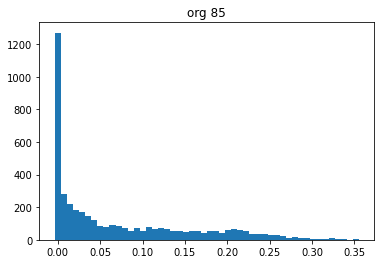

In [18]:
org_att = scipy.io.loadmat('att_splits_AWA2.mat')
org_att.keys()
org_att_flat = org_att['att'].flatten()
print(np.min(org_att_flat))
print(np.max(org_att_flat))
plt.hist(org_att_flat, bins = 50)
plt.title("org 85")
plt.show()

0.0
1.0


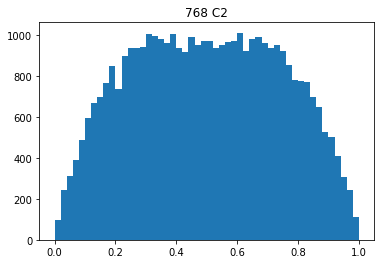

In [19]:
my_att = scipy.io.loadmat('myatt_splits768norm_C2.mat')
my_att_flat = my_att['att'].flatten()
print(np.min(my_att_flat))
print(np.max(my_att_flat))
plt.hist(my_att_flat, bins = 50)
plt.title("768 C2")
plt.show()

0.0
1.0


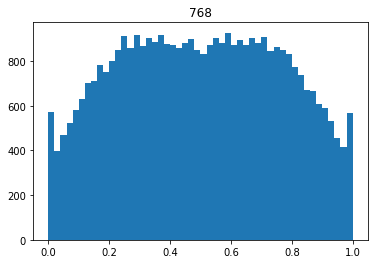

In [20]:
my_att = scipy.io.loadmat('myatt_splits768norm')
my_att_flat = my_att['att'].flatten()
print(np.min(my_att_flat))
print(np.max(my_att_flat))
plt.hist(my_att_flat, bins = 50)
plt.title("768")
plt.show()

0.0
1.0


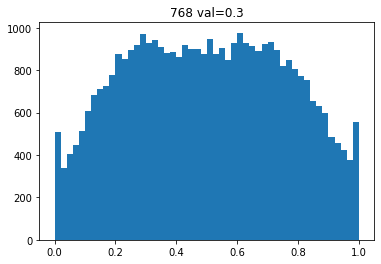

In [21]:
my_att = scipy.io.loadmat('myatt_splits768norm_0.3Val')
my_att_flat = my_att['att'].flatten()
print(np.min(my_att_flat))
print(np.max(my_att_flat))
plt.hist(my_att_flat, bins = 50)
plt.title("768 val=0.3")
plt.show()

0.0
1.0


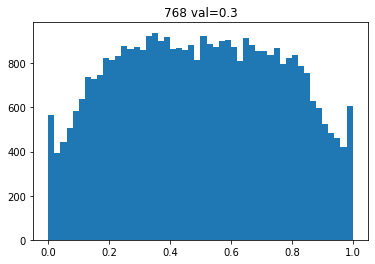

In [22]:
my_att = scipy.io.loadmat('myatt_splits768norm_0.1Val')
my_att_flat = my_att['att'].flatten()
print(np.min(my_att_flat))
print(np.max(my_att_flat))
plt.hist(my_att_flat, bins = 50)
plt.title("768 val=0.3")
plt.show()